# 02 - Latent Semantic Analysis (LSA)
This notebook performs Latent Semantic Analysis on the governance data set. It assumes the data was cleaned and placed in the cache by the "_00 - Preprocess the Governance Data Set__" notebook.

The code in this notebook is largely based on the [Introduction to Latent Semantic Analysis](https://www.youtube.com/playlist?list=PLroeQp1c-t3qwyrsq66tBxfR6iX6kSslt) youtube series by Joshua Cook.


---
## Dependencies and Imports
Here we import the libraries we need to perform our analysis.

In [1]:
!pip install scikit-learn pandas seaborn graphviz wordcloud

In [2]:
import re
import sys
from pathlib import Path
print("python=={}".format(re.sub(r'\s.*', '', sys.version)))

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import __version__ as sklearn__version__
print(f"scikit-learn=={sklearn__version__}")

import pandas as pd
print(f"pandas=={pd.__version__}")
ROW    = 0
COLUMN = 1
STRING = 'string'
OBJECT = 'object'
NUMBER = 'number'
CATEGORY = 'category'
INTEGER = 'integer'
UNSIGNED = 'unsigned'
FLOAT = 'float'

import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlib__version__
print(f"matplotlib=={matplotlib__version__}")

import seaborn as sns
CMAP_VLAG = sns.color_palette("vlag", as_cmap=True)
print(f"seaborn=={sns.__version__}")

from graphviz import __version__ as graphviz__version__
print(f"graphviz=={graphviz__version__}")
from graphviz import Source as dot_graph

import numpy as np
print(f"numpy=={np.__version__}")

from wordcloud import WordCloud
from wordcloud import __version__ as wordcloud__version__
print(f"wordcloud=={wordcloud__version__}")


python==3.11.4
scikit-learn==1.2.2
pandas==2.0.2
matplotlib==3.7.1
seaborn==0.12.2
graphviz==0.20.1
numpy==1.25.0
wordcloud==1.9.2


---
## Process Steps
The image below shows the process steps that we are taking in this notebook. The values for `min_df` and `max_df` are explained elsewhere.

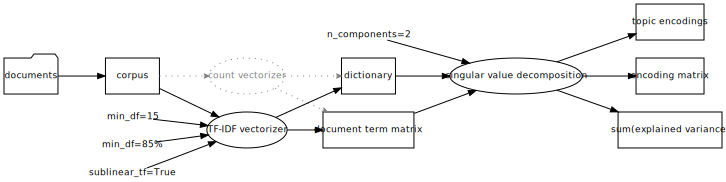

In [3]:
dot_graph('''
digraph {
  rankdir=LR;
  node [fontname="georgia; serif" fontsize=9, margin=0 arrowhead=normal arrowtail=dot];
  edge [arrowsize=0.75]

  node [shape=folder]; documents;
  node [shape=oval]; vec [label="count vectorizer", color=grey fontcolor=grey style=dotted];
      tfidf [label="TF-IDF vectorizer"]; svd [label="singular value decomposition"];
  node [shape=plain]; min_df [label="min_df=15"]; max_df [label="min_df=85%"];
      sublinear_tf [label="sublinear_tf=True"]; n_components [label="n_components=2"]; dot0 [label=" "];
  node [shape=box]; dtm [label="document term matrix"]; dict [label="dictionary"];
      topic_encodings [label="topic encodings"]; encoding_matrix [label="encoding matrix"]; explained_variance_sum [label="sum(explained variance)"];

  documents -> corpus;
  corpus -> vec [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  corpus -> tfidf;
  sublinear_tf -> tfidf;
  min_df -> tfidf;
  max_df -> tfidf;
  vec -> dtm [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dtm;
  vec -> dict [color=grey style=dotted arrowhead=vee arrowsize=0.5];
  tfidf -> dict;
  dtm -> svd;
  dict -> svd;
  n_components -> svd;
  svd -> topic_encodings;
  svd -> encoding_matrix;
  svd -> explained_variance_sum;
}
''')

In [4]:
# the caller is expected to select the right column from their data frame and
# pass it in as a series.
def compose_document_term_matrix(series, min_df, max_df, sublinear_tf):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, sublinear_tf=sublinear_tf)
    dt_matrix  = vectorizer.fit_transform(series)
    dictionary = vectorizer.get_feature_names_out()

    return pd.DataFrame(index=series.index, columns=dictionary, data=dt_matrix.toarray()), \
           dictionary

def perform_lsa(dt_matrix, dictionary, n_components, column_names=None):
    svd = TruncatedSVD(n_components=n_components)
    explained_variance_sum = svd.fit(dt_matrix).explained_variance_.sum()
    lsa = svd.transform(dt_matrix)
    if not column_names:
        column_names = [f"topic {n}" for n in range(lsa.shape[1])]

    return pd.DataFrame(index=dt_matrix.index, data=lsa, columns=column_names), \
           pd.DataFrame(index=column_names, data=svd.components_, columns=dictionary).T, \
           explained_variance_sum           

def n_most_significant(topic, n_terms, encoding_matrix):
    df = encoding_matrix[topic]
    return df.iloc[df.abs().argsort()][::-1][:n_terms].to_frame()


---
## Apply LSA to the Governance Data Set
We apply LSA to the subset _duurzaamheidsvisie_ (DV) documents from the governance data set.

### Load the DV Documents from the Governance Data

In [5]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

def load_corpus_as_dataframe(glob):
    df = pd.DataFrame(data   =[file.read_text() for file in expand_glob(glob)],
                      index  =[file.stem        for file in expand_glob(glob)],
                      columns=[DOCUMENT_BODY])
    df[DOCUMENT_BODY] = df[DOCUMENT_BODY].astype(STRING)

    return df


'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


In [6]:
MIN_DF = 15   # count
MAX_DF = 0.85 # percent
SUBLINEAR_TF = True


In [7]:
corpus = load_corpus_as_dataframe(GLOB_DV)
corpus


,body
GM0003DV02,duurzaamheidsbeleid Appingedam duurzaamheidsbe...
GM0005DV01,colofon gemeente bedum bezoekadres Schoolstraa...
GM0007DV01,Milieubeleidsplan vaststellen gemeenteraad bel...
GM0009DV01,inhoud duurzaamheidsvisie februari inhoud inho...
GM0034DV01,verseonnr dagmail december raad gemeente almer...
...,...
GM1945DV01,duurzaamheidsprogramma gemeente groesbeek duur...
GM1955DV01,milieuprogramma gemeente Montferland vaststell...
GM1955DV02,notitie ruimtelijk inpassing stroomopwekking z...
GM1955DV03,energietransitienota duurzaam energie achterho...


In [8]:
corpus.info()


<class 'pandas.core.frame.DataFrame'>
Index: 245 entries, GM0003DV02 to GM1987DV01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    245 non-null    string
dtypes: string(1)
memory usage: 3.8+ KB


In [9]:
document_term_matrix, dictionary = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=MIN_DF, max_df=MAX_DF, sublinear_tf=SUBLINEAR_TF)
document_term_matrix


,aanbested,aanbesteding,aanbestedingen,aanbestedingsbeleid,aanbestedingstraject,aanbeveling,aanbieden,aanbieder,aanbieding,aanbod,...,zuidoost,zuinig,zuiniger,zuiveren,zuivering,zwaar,zwart,zwembad,zwerfafval,zwerfvuil
GM0003DV02,0.00000,0.011961,0.000000,0.000000,0.000000,0.038088,0.029612,0.0,0.0,0.012241,...,0.0,0.032091,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GM0005DV01,0.00000,0.014458,0.000000,0.000000,0.000000,0.000000,0.012821,0.0,0.0,0.000000,...,0.0,0.025169,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.091655,0.000000
GM0007DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017467,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.015561,0.000000,0.000000,0.037044,0.049653
GM0009DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018100,0.0,0.0,0.035368,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.033804,0.000000,0.000000
GM0034DV01,0.00000,0.015308,0.028343,0.000000,0.000000,0.000000,0.013575,0.0,0.0,0.000000,...,0.0,0.015739,0.0,0.000000,0.031880,0.034670,0.036210,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GM1945DV01,0.00000,0.022688,0.017603,0.026454,0.045707,0.000000,0.014275,0.0,0.0,0.000000,...,0.0,0.016551,0.0,0.033125,0.000000,0.021533,0.000000,0.000000,0.000000,0.000000
GM1955DV01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022652,0.0,0.0,0.015440,...,0.0,0.000000,0.0,0.000000,0.000000,0.048157,0.000000,0.000000,0.000000,0.000000
GM1955DV02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.026038,...,0.0,0.026160,0.0,0.000000,0.000000,0.000000,0.060182,0.000000,0.000000,0.000000
GM1955DV03,0.00000,0.000000,0.000000,0.000000,0.000000,0.084665,0.013597,0.0,0.0,0.015692,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [10]:
dictionary

array(['aanbested', 'aanbesteding', 'aanbestedingen', ..., 'zwembad',
       'zwerfafval', 'zwerfvuil'], dtype=object)

In [11]:
topic_encodings, encoding_matrix, _ = perform_lsa(document_term_matrix, dictionary, 2)
topic_encodings


,topic 0,topic 1
GM0003DV02,0.566258,-0.088313
GM0005DV01,0.514658,0.357781
GM0007DV01,0.542931,0.367700
GM0009DV01,0.454025,-0.103691
GM0034DV01,0.484799,-0.053750
...,...,...
GM1945DV01,0.626101,-0.037399
GM1955DV01,0.469120,0.359925
GM1955DV02,0.404564,-0.091554
GM1955DV03,0.504876,-0.091597


In [12]:
encoding_matrix


,topic 0,topic 1
aanbested,0.014110,-0.009774
aanbesteding,0.024423,0.000792
aanbestedingen,0.009246,-0.001441
aanbestedingsbeleid,0.011459,-0.006629
aanbestedingstraject,0.005343,0.001837
...,...,...
zwaar,0.015062,0.016467
zwart,0.005122,-0.005594
zwembad,0.012588,-0.009664
zwerfafval,0.020227,0.045361


In [13]:
n_most_significant("topic 0", 20, encoding_matrix)


,topic 0
eur,0.049944
afval,0.049168
maatschappelijk,0.046794
water,0.046491
wij,0.045539
programma,0.045537
natuur,0.045243
mobiliteit,0.044971
ruimtelijk,0.044866
communicatie,0.044820


In [14]:
n_most_significant("topic 1", 20, encoding_matrix)


,topic 1
gevaarlijk,0.101752
geluid,0.091749
melding,0.088102
milieutak,0.085933
veiligheid,0.084879
omgevingsvergunning,0.080963
bodemkwaliteit,0.080097
wabo,0.079299
milieubeleidsplan,0.078219
milieubeleid,0.076570


### Determine the correct number of topics using latent sementic analysis
Explained variance based on https://stackoverflow.com/questions/69091520/determine-the-correct-number-of-topics-using-latent-semantic-analysis

In [15]:
performance = []
test = range(1, 255)

for n in test: #removed the loop for reasons of performance
    _, _, explained_variance_sum = perform_lsa(document_term_matrix, dictionary, n)
    performance.append(explained_variance_sum)


(1.0, 255.0)

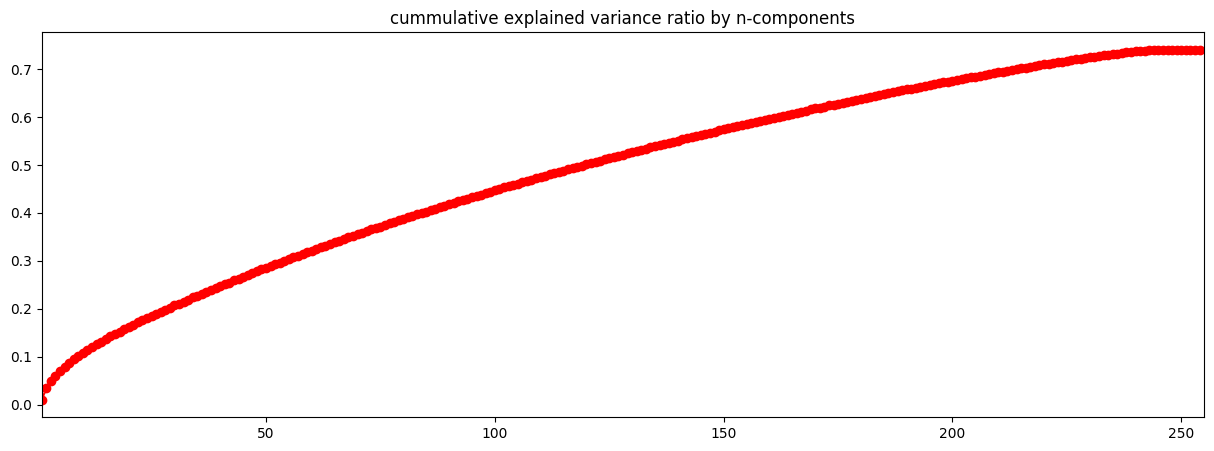

In [16]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, performance, 'ro--')
plt.title('cummulative explained variance ratio by n-components')
plt.xlim(1, 255)


70 to 80% of the explained variance ratio is reached with 125 to 150 topics.

(0.0, 25.0)

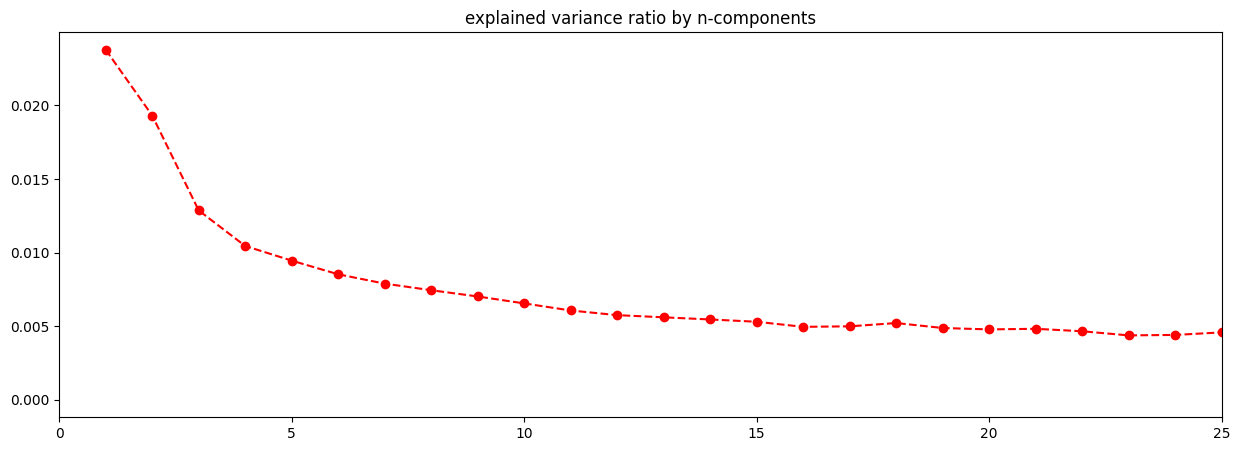

In [17]:
fig = plt.figure(figsize=(15, 5))
plt.plot(test, np.gradient(performance), 'ro--')
plt.title('explained variance ratio by n-components')
plt.xlim(0, 25) # zoom to 25 to see the changes in the first components


The graph shows that the explained variance of the LSA model is about 75% at maximum of 253 topics (= number of documents). This low explained variance is probably due to the relative few but lengthy documents.
The explained variance flattens around 4 topics.

### Determining the beste parameters for the TF-IDF matrix in the LSA context
Below a matrix is constructed for different values of the min_df (absolute values) and max_df (relative values) settings for constructing the TF-IDF matrix. These are evaluated for the total explained variance and the explained variance in the first 5 topics from the LSA. Also the topic composition of the resulting topics are compared.

In [18]:
min_ls = [0, 5, 10, 15, 20, 25, 35, 50]
max_ls = [0.5, 0.75, 0.85, 0.9, 0.95, 1.0]
dimensions = pd.DataFrame(index=min_ls, columns=max_ls)
exvar_tot =  pd.DataFrame(index=min_ls, columns=max_ls)
exvar_5 =    pd.DataFrame(index=min_ls, columns=max_ls)
words = [[None] * len(max_ls)] * len(min_ls)


In [19]:
i = 0
for min_df in min_ls:
    c = 0
    for max_df in max_ls:
        dtm, dict = compose_document_term_matrix(corpus[DOCUMENT_BODY], min_df=min_df, max_df=max_df, sublinear_tf=SUBLINEAR_TF)
        dimensions.loc[min_df, max_df] = dict.size

        # calculate total variance, using n=255
        _, _, expl_variance_sum = perform_lsa(dtm, dict, 255)
        exvar_tot.loc[min_df, max_df] = expl_variance_sum

        # calculate variance at 5 topics, using n=5
        _, enc_matrix, expl_variance_sum = perform_lsa(dtm, dict, 5)
        words[i][c] = enc_matrix
        exvar_5.loc[min_df, max_df] = expl_variance_sum

        c += 1
    i += 1


In [20]:
dimensions


,0.50,0.75,0.85,0.90,0.95,1.00
0,64724,65103,65209,65258,65305,65349
5,9492,9871,9977,10026,10073,10117
10,5433,5812,5918,5967,6014,6058
15,3840,4219,4325,4374,4421,4465
20,3001,3380,3486,3535,3582,3626
25,2443,2822,2928,2977,3024,3068
35,1736,2115,2221,2270,2317,2361
50,1111,1490,1596,1645,1692,1736


In [21]:
exvar_tot


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.930351,0.896651,0.881584,0.87237,0.861807,0.84561
5,0.882631,0.832575,0.810544,0.797195,0.781982,0.758837
10,0.854603,0.796406,0.770991,0.755646,0.738215,0.711819
15,0.832383,0.768296,0.740449,0.723682,0.704685,0.675997
20,0.814648,0.746151,0.716505,0.698694,0.678553,0.648218
25,0.798929,0.726655,0.695473,0.676773,0.655667,0.623948
35,0.77057,0.691748,0.657927,0.637706,0.614957,0.580903
50,0.731814,0.644921,0.607854,0.585774,0.561041,0.52422


High total explained variances are achieved for low values of both `min_df` and `max_df`. For `min_df` this is the result of including words that are unique for only a few documents. For `max_df` it is most likely because the total number of word occurances are reduces, which reduces the total variance.

In [22]:
exvar_5


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.044175,0.045898,0.04563,0.045343,0.044739,0.044252
5,0.059144,0.060076,0.059015,0.058302,0.057184,0.055795
10,0.065907,0.066845,0.065383,0.064287,0.06282,0.06101
15,0.070868,0.071441,0.069522,0.068159,0.066372,0.064173
20,0.074719,0.074822,0.072508,0.070937,0.068861,0.066336
25,0.077481,0.077124,0.074476,0.072717,0.070392,0.067608
35,0.081694,0.08066,0.077337,0.075151,0.072364,0.069023
50,0.085641,0.083504,0.079239,0.076531,0.073111,0.069104


In [23]:
exvar_5 / exvar_tot


,0.50,0.75,0.85,0.90,0.95,1.00
0,0.047482,0.051188,0.051759,0.051977,0.051913,0.052331
5,0.067008,0.072157,0.072809,0.073133,0.073126,0.073527
10,0.07712,0.083933,0.084804,0.085076,0.085097,0.085709
15,0.085139,0.092986,0.093892,0.094183,0.094187,0.094931
20,0.091719,0.100277,0.101197,0.101527,0.101483,0.102336
25,0.096981,0.106136,0.107087,0.107447,0.107359,0.108355
35,0.106018,0.116603,0.117547,0.117845,0.117673,0.118821
50,0.117026,0.129479,0.130358,0.130649,0.130312,0.131822


The first five topics explain most of the variance with a high max_df and low min_df. The explained variance ratio is largest at high max_df and high max_df, however this ratio reduces only slightly for medium values of max_df. So the influence of max_df is mainly influenced by the higher total explained variance. The effect of min_df is explained by less unique words for the documents (so the other topics are less able to explain variance).

### Influence of `min_df` and `max_df` on Topic Interpretation
Below the top 20 words in each topic are listed in order to be able to interprete the common theme within the topic. The influence of different min_df and max_df settings can be investegated by changing the index of the words matrix (see matrices above).

Topic labelling seems quite stable for most options of min_df and max_df. Only values of max_df <= 0.75 the label of the two last topics changes. These two topics seems to have quite a similar theme. It is concluded that low values of max_df results in less intepretable topics.

Topic composition is influenced only slightly by different values of `max_df` and `min_df`. Low values of `max_df` seems to reduce the explainability of the topics.

From this analysis it can be concluded that medium values for both max_df and min_df results in a good balance between total explained variance and the explained variance of the first five topics. For our analysis it is proposed to use min_df = 15 and max_df = 0.85

### Topic assessment with 5 topics
According to the elbow method 5 topics are optimal to assess the information in the documents. Below these 5 topics are assessed for their content and value for clustering.

In [24]:
topic_encodings, encoded_matrix, _ = perform_lsa(document_term_matrix, dictionary, 4,
                                                ['samenleving', 'milieu', 'mens en natuur', 'energie']) #, 'energie/afval'])
topic_encodings


,samenleving,milieu,mens en natuur,energie
GM0003DV02,0.566258,-0.088251,-0.004638,-0.033011
GM0005DV01,0.514658,0.357809,-0.080503,-0.025240
GM0007DV01,0.542931,0.367682,0.035065,-0.058191
GM0009DV01,0.454025,-0.103651,0.098333,-0.017906
GM0034DV01,0.484799,-0.053707,0.150375,0.018383
...,...,...,...,...
GM1945DV01,0.626101,-0.037403,-0.044820,-0.095743
GM1955DV01,0.469120,0.359891,-0.168904,0.161842
GM1955DV02,0.404564,-0.091540,0.020339,-0.082548
GM1955DV03,0.504876,-0.091566,-0.141150,-0.055637


The first 5 topics only account for 6.6% of the explained variance between the documents.
\

In [25]:
encoded_matrix


,samenleving,milieu,mens en natuur,energie
aanbested,0.014110,-0.009766,-0.005114,0.029492
aanbesteding,0.024423,0.000796,-0.004313,0.019431
aanbestedingen,0.009246,-0.001434,0.008710,0.004487
aanbestedingsbeleid,0.011459,-0.006629,0.004557,0.010673
aanbestedingstraject,0.005343,0.001846,-0.006822,0.012790
...,...,...,...,...
zwaar,0.015062,0.016454,0.005655,-0.013789
zwart,0.005122,-0.005597,0.009614,-0.003723
zwembad,0.012588,-0.009668,-0.007304,0.023144
zwerfafval,0.020227,0.045395,0.014740,0.031401


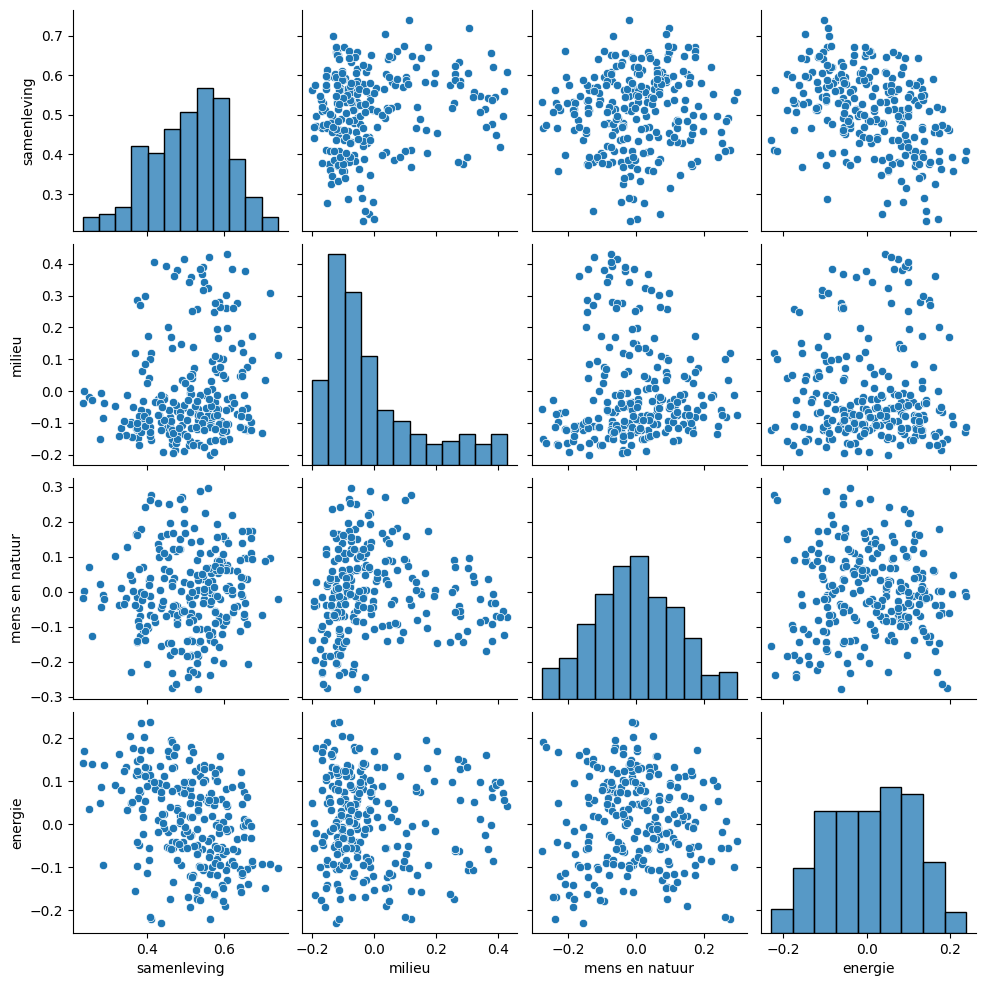

In [26]:
topic_encodings.to_parquet("../data/Governance/LSA_document_topic_matrix.parquet")
sns.pairplot(topic_encodings);


---
## Generate Word Clouds per Topic

In [27]:
def wordcloud_of_topic(series):
    print(series.sort_values(ascending=False)[:20])
    cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(series.sort_values(ascending=False))
    plt.axis('off')
    plt.imshow(cloud);


eur                0.049944
afval              0.049168
maatschappelijk    0.046794
water              0.046491
wij                0.045539
programma          0.045537
natuur             0.045243
mobiliteit         0.044971
ruimtelijk         0.044866
communicatie       0.044820
extern             0.043928
regio              0.043753
ondernemer         0.043601
actie              0.043277
vaststellen        0.043270
concreet           0.043086
overheid           0.043063
verlichting        0.042938
huidig             0.042903
economisch         0.042903
Name: samenleving, dtype: float64


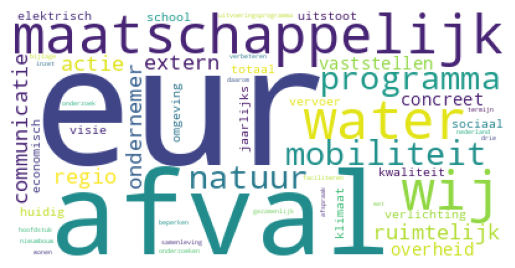

In [28]:
wordcloud_of_topic(encoded_matrix['samenleving'])


gevaarlijk             0.101744
geluid                 0.091746
melding                0.088077
milieutak              0.085914
veiligheid             0.084859
omgevingsvergunning    0.080943
bodemkwaliteit         0.080083
wabo                   0.079268
milieubeleidsplan      0.078225
milieubeleid           0.076574
vergunningverlening    0.075339
milieuprogramma        0.073669
sanering               0.072818
klacht                 0.072408
besluit                0.070504
luchtkwaliteit         0.069596
toezicht               0.068311
handhaving             0.066482
stof                   0.066444
bodembeheer            0.065845
Name: milieu, dtype: float64


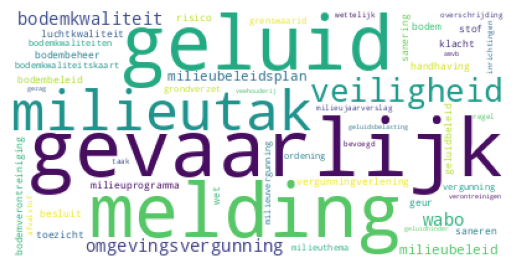

In [29]:
wordcloud_of_topic(encoded_matrix['milieu'])


ecologisch            0.081586
stad                  0.072322
verbinding            0.065194
biodiversiteit        0.065161
cradle                0.065030
sociaal               0.064975
leven                 0.062187
circulair             0.058583
duurzaamheidsvisie    0.058052
voedsel               0.056692
diversiteit           0.055962
planet                0.054759
people                0.054409
natuur                0.052085
toekomstbestendig     0.051291
plek                  0.050508
gezond                0.048819
generatie             0.048150
identiteit            0.047910
balans                0.047830
Name: mens en natuur, dtype: float64


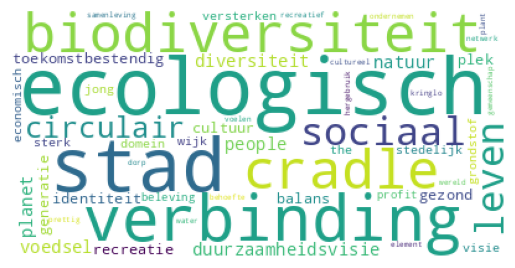

In [30]:
wordcloud_of_topic(encoded_matrix['mens en natuur'])


eur                0.077946
laadpaal           0.077365
energieakkoord     0.071538
samenleving        0.067430
ondernemer         0.065606
faciliteren        0.064532
zonnepanelen       0.064118
college            0.063404
planning           0.062490
circulair          0.062352
afval              0.061496
gemeentehuis       0.059503
restafval          0.058585
fairtrade          0.058251
werkgroep          0.057455
budget             0.057165
omgevingsdienst    0.056482
raad               0.056359
afvalscheiding     0.055115
organiseren        0.055107
Name: energie, dtype: float64


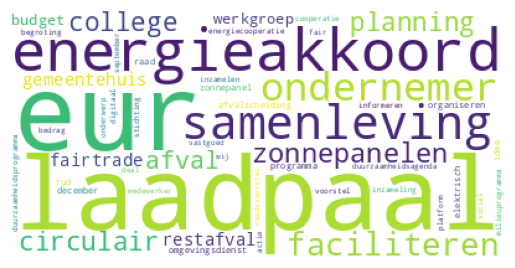

In [31]:
wordcloud_of_topic(encoded_matrix['energie'])
